In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install sdv

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

In [5]:
# read csv file as dataframe, and drop ROW_ID column
def read_csv_no_rowid(file_path):
    df = pd.read_csv(file_path)
    df.drop(["Unnamed: 0", 'row_id'], axis=1, inplace=True)

    return df

In [6]:
# check NaN value

def nan_count(df):
    print("Total columns: " + str(len(df.columns)))
    print("Total rows: " + str(len(df)))
    print("--------------")
    print(df.isnull().sum())

In [7]:
date_set_path = "../temp_sets_100/"

In [8]:
procedureevents_mv_df = read_csv_no_rowid(date_set_path + "procedureevents_mv.csv")

In [9]:
procedureevents_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,value,valueuom,location,locationcategory,...,ordercategoryname,secondaryordercategoryname,ordercategorydescription,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date
0,62019,150112,253642,2157-02-06 15:55:00,2157-02-07 01:52:00,224275,597.0,min,NaN,NaN,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
1,62019,150112,253642,2157-02-06 15:56:00,2157-02-07 01:52:00,224275,596.0,min,NaN,NaN,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN
2,62019,150112,253642,2157-02-06 17:00:00,2157-02-06 17:01:00,225459,1.0,None,NaN,NaN,...,Imaging,NaN,Electrolytes,0,0,0,FinishedRunning,NaN,NaN,NaN
3,62019,150112,253642,2157-02-07 00:10:00,2157-02-07 00:11:00,225402,1.0,None,NaN,NaN,...,Procedures,NaN,Electrolytes,0,0,0,FinishedRunning,NaN,NaN,NaN
4,31585,125380,234741,2100-07-03 01:14:00,2100-07-04 01:57:00,224277,1483.0,min,NaN,NaN,...,Peripheral Lines,NaN,Task,1,0,0,FinishedRunning,NaN,NaN,NaN


In [10]:
# Drop some null value
# procedureevents_mv_df.dropna(subset=['hadm_id', ], inplace=True, axis=0)

In [11]:
# Drop some columns
procedureevents_mv_df.drop(['location', 'locationcategory', 'storetime', 'cgid', 'secondaryordercategoryname', 
    'continueinnextdept', 'cancelreason', 'comments_editedby', 'comments_canceledby', 'comments_date'], axis=1, inplace=True)

In [12]:
nan_count(procedureevents_mv_df)

Total columns: 14
Total rows: 695
--------------
subject_id                  0
hadm_id                     0
icustay_id                  0
starttime                   0
endtime                     0
itemid                      0
value                       0
valueuom                    0
orderid                     0
linkorderid                 0
ordercategoryname           0
ordercategorydescription    0
isopenbag                   0
statusdescription           0
dtype: int64


In [13]:
# Deal with null values
# procedureevents_mv_df['value'].fillna(value=0, inplace=True)

In [14]:
procedureevents_mv_df.dtypes

subject_id                    int64
hadm_id                       int64
icustay_id                    int64
starttime                    object
endtime                      object
itemid                        int64
value                       float64
valueuom                     object
orderid                       int64
linkorderid                   int64
ordercategoryname            object
ordercategorydescription     object
isopenbag                     int64
statusdescription            object
dtype: object

In [15]:
# procedureevents_mv_df['subject_id'] = procedureevents_mv_df['subject_id'].astype(str)
# procedureevents_mv_df['hadm_id'] = procedureevents_mv_df['hadm_id'].astype(str)
# procedureevents_mv_df['icustay_id'] = procedureevents_mv_df['icustay_id'].astype(str)

# procedureevents_mv_df['itemid'] = procedureevents_mv_df['itemid'].astype(str)
# procedureevents_mv_df['orderid'] = procedureevents_mv_df['orderid'].astype(str)
# procedureevents_mv_df['linkorderid'] = procedureevents_mv_df['linkorderid'].astype(str)

procedureevents_mv_df['starttime'] = pd.to_datetime(procedureevents_mv_df['starttime'])
procedureevents_mv_df['endtime'] = pd.to_datetime(procedureevents_mv_df['endtime'])

In [16]:
procedureevents_mv_df.dtypes

subject_id                           int64
hadm_id                              int64
icustay_id                           int64
starttime                   datetime64[ns]
endtime                     datetime64[ns]
itemid                               int64
value                              float64
valueuom                            object
orderid                              int64
linkorderid                          int64
ordercategoryname                   object
ordercategorydescription            object
isopenbag                            int64
statusdescription                   object
dtype: object

In [17]:
invalid_index = procedureevents_mv_df.loc[(procedureevents_mv_df['starttime'] > procedureevents_mv_df['endtime']) == True].index
procedureevents_mv_df.drop(invalid_index, inplace=True, axis=0)

In [18]:
len(procedureevents_mv_df)

695

---

## Build model

In [19]:
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate
from sdv.constraints import FixedCombinations
from sdv.constraints import Inequality

In [20]:
procedureevents_mv_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'itemid',
       'value', 'valueuom', 'orderid', 'linkorderid', 'ordercategoryname',
       'ordercategorydescription', 'isopenbag', 'statusdescription'],
      dtype='object')

In [21]:
fixed_subject_hadm_icustay_constraint = FixedCombinations(
    column_names=['subject_id', 'hadm_id', 'icustay_id']
)
fixed_itemid_value_valueuom_constraint = FixedCombinations(
    column_names=['itemid', 'value', 'valueuom']
)

fixed_itemid_orderid_linkorderid_constraint = FixedCombinations(
    column_names=['orderid', 'linkorderid', 'ordercategoryname', 'ordercategorydescription']
)

starttime_endtime_constraint = Inequality(
    low_column_name='starttime',
    high_column_name='endtime'
)

In [22]:
procedureevents_mv_constraints = [fixed_subject_hadm_icustay_constraint, fixed_itemid_value_valueuom_constraint, fixed_itemid_orderid_linkorderid_constraint, starttime_endtime_constraint]

In [23]:
model = CTGAN(
    constraints=procedureevents_mv_constraints, 
    batch_size=1000,
    generator_lr=0.001,
    discriminator_lr=0.001,
    cuda=True, 
    verbose=True, 
    epochs=210)

In [24]:
len(procedureevents_mv_df)

695

In [25]:
train_data = procedureevents_mv_df
model.fit(train_data)

Epoch 1, Loss G:  3.7063,Loss D:  0.0021
Epoch 2, Loss G:  3.6976,Loss D: -0.0283
Epoch 3, Loss G:  3.7021,Loss D: -0.0528
Epoch 4, Loss G:  3.4543,Loss D: -0.1202
Epoch 5, Loss G:  3.4799,Loss D: -0.1221
Epoch 6, Loss G:  3.6562,Loss D: -0.0999
Epoch 7, Loss G:  3.5267,Loss D: -0.0480
Epoch 8, Loss G:  3.4692,Loss D: -0.0385
Epoch 9, Loss G:  3.4622,Loss D: -0.0484
Epoch 10, Loss G:  3.6803,Loss D: -0.0993
Epoch 11, Loss G:  3.6286,Loss D: -0.1837
Epoch 12, Loss G:  3.6764,Loss D: -0.2196
Epoch 13, Loss G:  3.6197,Loss D: -0.1736
Epoch 14, Loss G:  3.3977,Loss D: -0.0338
Epoch 15, Loss G:  3.2098,Loss D:  0.1197
Epoch 16, Loss G:  3.0815,Loss D:  0.2652
Epoch 17, Loss G:  3.0343,Loss D:  0.2831
Epoch 18, Loss G:  3.0231,Loss D:  0.2084
Epoch 19, Loss G:  3.0455,Loss D:  0.0914
Epoch 20, Loss G:  2.9270,Loss D:  0.0053
Epoch 21, Loss G:  3.2888,Loss D: -0.0395
Epoch 22, Loss G:  3.1448,Loss D: -0.1101
Epoch 23, Loss G:  3.3668,Loss D: -0.1701
Epoch 24, Loss G:  3.3018,Loss D: -0.2543
E

In [26]:
model.save(date_set_path + "100_models/" + "procedureevents_mv_model.pkl")

In [27]:
# model = CTGAN.load(("/content/drive/MyDrive/MSc Project/procedureevents_mv_model.pkl"))

In [28]:
sample = model.sample(num_rows=1000)

Sampling rows: 100%|██████████| 1000/1000 [00:00<00:00, 8877.79it/s]


In [29]:
len(sample)

1000

In [30]:
nan_count(sample)

Total columns: 14
Total rows: 1000
--------------
subject_id                  0
hadm_id                     0
icustay_id                  0
starttime                   0
endtime                     0
itemid                      0
value                       0
valueuom                    0
orderid                     0
linkorderid                 0
ordercategoryname           0
ordercategorydescription    0
isopenbag                   0
statusdescription           0
dtype: int64


In [31]:
sample.dtypes

subject_id                           int64
hadm_id                              int64
icustay_id                           int64
starttime                   datetime64[ns]
endtime                     datetime64[ns]
itemid                               int64
value                              float64
valueuom                            object
orderid                              int64
linkorderid                          int64
ordercategoryname                   object
ordercategorydescription            object
isopenbag                            int64
statusdescription                   object
dtype: object

In [32]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.7256487273627613

In [33]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.4884350468260766

<AxesSubplot:xlabel='itemid', ylabel='value'>

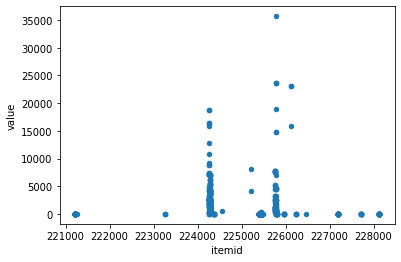

In [34]:
sample.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:xlabel='itemid', ylabel='value'>

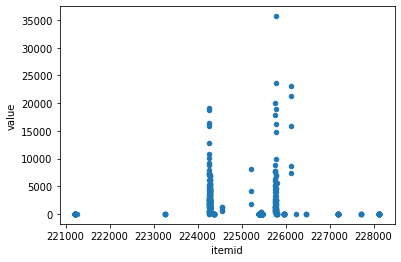

In [35]:
train_data.sort_values('itemid').plot(x='itemid', y='value', kind='scatter')

<AxesSubplot:>

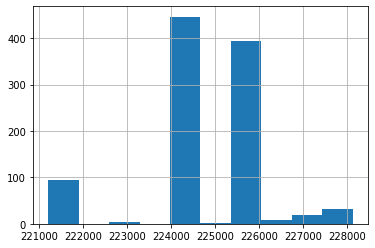

In [36]:
sample.sort_values('itemid')['itemid'].hist()

<AxesSubplot:>

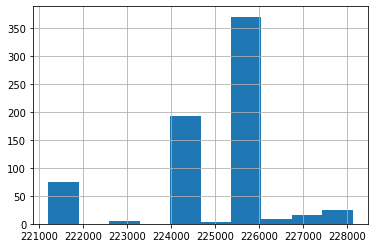

In [37]:
train_data.sort_values('itemid')['itemid'].hist()

In [38]:
# evaluate(sample, train_data, aggregate=False)